# **Data Cleaning Notebook**

## Objectives

* Data Exploration using ProfileReport
* Correlation and PPS Analysis
* Detailed evaluation of missing data
* Imputing of missing data
* Split Train and Test Sets

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate cleaned Train and Test sets, saved under outputs/datasets/cleaned 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Load collected data

In [13]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Data Exploration

We use ProfileReport to get more familiar with the dataset. It will tell use variable types and distribution, missing data levels, etc.

In [ ]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

The report on the data set reveals that of the 24 columns, 20 contain numerical values and 4 text/categorical values. A closer look at the detailed information on each variable shows that two of the numerical variables, OverallCond and OverallQual, are also categorical data, which are encoded numerically. Overall approximately 10% of data are missing.

## Correlation and PPS Analysis

We carry out an initial assessment of the relationship between the different variables/features/data. We use custom functions from the CI Walkthrough project 2.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps



def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


We use CalculateCorrAndPPS function to calculate Correlations and Predictive Power Score.

In [ ]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

In [ ]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.2, PPS_Threshold = 0.15,
                  figsize=(12,10), font_annot = 10)

## Reports on variables with missing data

In [14]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [ ]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

A closer look at the columns with missing data shows that in total 9 columns are missing data and a total of roughly 26% of cells are missing data. 

Another, more concise, way to look at the missing data is with the custom function from the CI Walkthrough Project 2, called EvaluateMissingData. It evalutes the number of missing data values for each variable and the overall percentage of missing data for each variable. I returns the values in a padas dataframe.

In [15]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
        data={"RowsWithMissingData": missing_data_absolute,
              "PercentageOfDataset": missing_data_percentage,
              "DataType": df.dtypes}
    )
                       .sort_values(by=['PercentageOfDataset'], ascending=False)
                       .query("PercentageOfDataset > 0")
                      )
    return df_missing_data
    

In [16]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In the following cell we replace missing values in the BasementType and GarageFinish categories by the string 'Missing' and plot the type of basement finish against finished and unfinished basement square footage. We can see that some basements in the missing category have finished and some have unfinished square footage, this may give us a more nuanced idea what values to replace the missing data with. However, since the correlation analysis showes that these variables do not have strong correlation with the sale price of the properties it may make sense to simply impute the values of the most common type of basement finish with is unfinished (UNF).

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

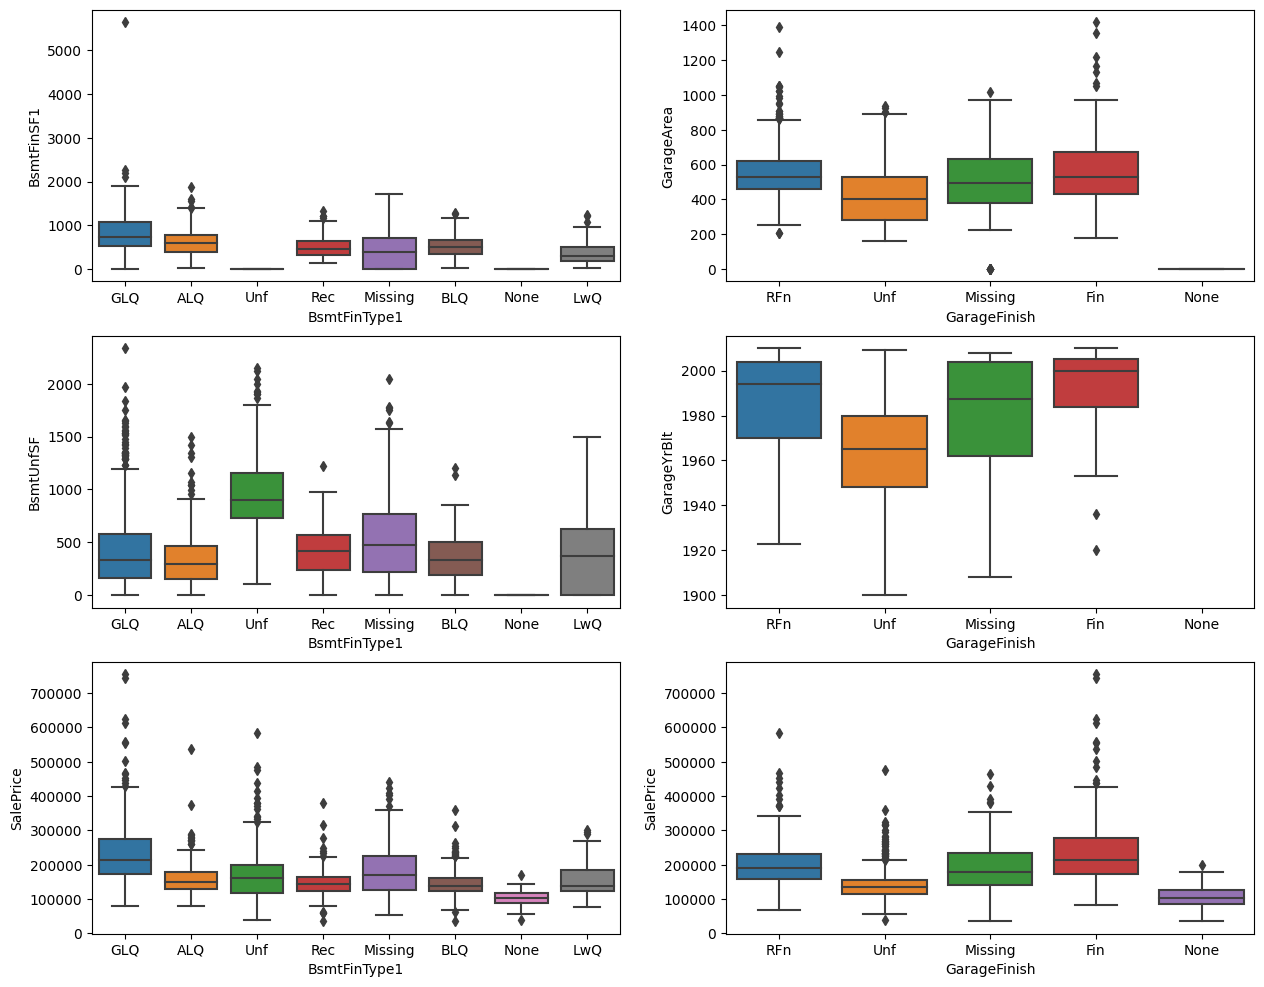

In [10]:
import seaborn as sns

df_missing = df
df_missing['BsmtFinType1']=df_missing['BsmtFinType1'].fillna('Missing')
df_missing['GarageFinish']=df_missing['GarageFinish'].fillna('Missing')
# df_missing['GarageYrBlt']=df_missing['GarageYrBlt'].fillna(1800)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
sns.boxplot(data=df_missing, x='BsmtFinType1', y='BsmtFinSF1', ax=axes[0,0])
sns.boxplot(data=df_missing, x='BsmtFinType1', y='BsmtUnfSF', ax=axes[1,0])
sns.boxplot(data=df_missing, x='BsmtFinType1', y='SalePrice', ax=axes[2,0])

sns.boxplot(data=df_missing, x='GarageFinish', y='GarageArea', ax=axes[0,1])
sns.boxplot(data=df_missing, x='GarageFinish', y='GarageYrBlt', ax=axes[1,1])
sns.boxplot(data=df_missing, x='GarageFinish', y='SalePrice', ax=axes[2,1])


In [ ]:
import pingouin as pg

pg.normality(df, dv='SalePrice',group='BsmtFinType1', alpha =0.05)

In [ ]:
pg.kruskal(data=df, dv='SalePrice', between='BsmtFinType1')

The variables 'EnclosedPorch' and 'WoodDeckSF' both a missing a significant amount of data, around 90%. The missing data levels in the other variables is less than 20%. We will not look at how to deal with the missing data going forward.

## Proposal for cleaning/imputing missing data

Data collection is expensive and data is valuable, therefore we want to preserve as much of it as possible and instead of dropping data instances or deleting variables from the data set, we will assess how we can best impute the missing values. The following table summarizes how we propose to handle the missing data for each variable.

| Variable | # of missing cells | % of missing cells | Discussion and solution |
| ---- | ----- | ---- | ------- |
| **EnclosedPorch** | 1324 | 90.68 | Enclosed porch area in square feet with over 90% of datapoints missing. Those that do exist are predominantly 0, as seen in the report above, indicating that there is no enclosed porch present. It is a relatively safe assumption that the missing data also indicate that no enclosed porch is present and we can thus impute the missing values as 0. |
| **WoodDeckSF** | 1305 | 89.38 | Wood deck area in square feet with almost 90% of data points missing. We make an analogous inference here as that above for the enclosed porch data and will impute the  missing values as 0.  |
| **LotFrontage** | 259 | 17.74 | The data show a mean of 70 and a median of 69 with a standard deviation of 24.3. Since the mean and median are so close and the graph looks to be roughly normally distributed, we can imput the median for the missing values.  |
| **GarageFinish** | 162 | 11.10 |  |
| **BsmtFinType1** | 114 | 7.81 |  |
| **BedroomAbvGr** | 99 | 6.78 |  |
| **2ndFlrSF** | 86 | 5.89 | 2nd floor square feet with about 6% of data missing. Over 50% of the data present are 0, indicating that no second floor is present, we can thus assume that the missing data also indicate that no second floor is present and we will impute the data with value 0. |
| **GarageYrBlt** | 81 | 5.55 |  |
| **MasVnrArea** | 8 | 0.55 | Masonry veneer area in square feet with only 0.55% of data missing. Following the same logic as for the enclosed porch data we will impute the missing data values as 0, indicating no masonry veneer area is present. |

---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
